# W281 Final Project: Intel Image Classification Model #

### Libraries

In [2]:
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from collections import Counter
import gc

from PIL import Image
from tqdm import tqdm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout,BatchNormalization,MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model, Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.feature import hog
from skimage import io, color

### Data Load

In [3]:
def load_data(datasets):
    
    output = []

    for dataset in datasets:
        images, labels = [], []
        print(f"Loading {dataset}...")
        i = 0
        for folder in os.listdir(dataset):
            label = i # Converting word labels to int (i.e. buildings = 0)
            i = i+1
            folder_path = os.path.join(dataset, folder)

            for file in tqdm(os.listdir(folder_path), desc=f"Processing {folder}"):
                img_path = os.path.join(folder_path, file)

                image = Image.open(img_path).resize((150, 150))
                images.append(image)
                labels.append(label)
                
        images = np.stack(images)
        labels = np.array(labels, dtype='int32')
        output.append((images, labels))
        
    return output

In [4]:
datasets = [r"C:\Users\aolay\OneDrive\Documents\MIDS\DataSci 281\Final Project\w281_Fall2024_FinalProject_Brown_Benzoni_Olaya\seg_train", 
        r"C:\Users\aolay\OneDrive\Documents\MIDS\DataSci 281\Final Project\w281_Fall2024_FinalProject_Brown_Benzoni_Olaya\seg_test"]

train_path, test_path = datasets

In [5]:
(train_images, train_labels), (test_images, test_labels) = load_data(datasets)

Loading C:\Users\aolay\OneDrive\Documents\MIDS\DataSci 281\Final Project\w281_Fall2024_FinalProject_Brown_Benzoni_Olaya\seg_train...


Processing street: 100%|██████████| 2382/2382 [00:02<00:00, 956.56it/s] 


Loading C:\Users\aolay\OneDrive\Documents\MIDS\DataSci 281\Final Project\w281_Fall2024_FinalProject_Brown_Benzoni_Olaya\seg_test...


Processing Street: 100%|██████████| 501/501 [00:00<00:00, 1004.94it/s]


In [6]:
# Reshape images into 2D array (flatten each image)
# Flatten the data for Random Forest & SVM
train_images_flat = train_images.reshape(len(train_images), -1)
test_images_flat = test_images.reshape(len(test_images), -1)

### Clean Data

In [7]:
# Normalization
train_images = train_images / 255.0 
test_images = test_images / 255.0

### Feature Extraction

#### HSV Feature Extraction

In [8]:
def create_hsv_feature_vectors(images, bins=32):
    all_hsv_features = []
    
    for img in tqdm(images):
        # Convert RGB to HSV
        hsv_img = color.rgb2hsv(img)
        
        hsv_features = hsv_img.reshape(-1)  # Flattens to 1D array
        
        all_hsv_features.append(hsv_features)
    
    # Convert to numpy array
    feature_vectors = np.array(all_hsv_features)
    
    return feature_vectors

In [ ]:
# Use it on your datasets
train_hsv_features = create_hsv_feature_vectors(train_images)
test_hsv_features = create_hsv_feature_vectors(test_images)

  0%|          | 0/14034 [00:00<?, ?it/s]

 48%|████▊     | 6683/14034 [00:55<00:54, 135.15it/s]

#### HOG Feature Extraction

In [10]:
def create_hog_feature_vectors(images):
    
    # Initialize list to store HOG features for each image
    all_hog_features = []
    
    # Process each image individually
    for img in tqdm(images):

        # Convert single image to grayscale
        gray_img = color.rgb2gray(img)
        
        # Calculate HOG features for image
        hog_features, _= hog(
            gray_img,
            orientations=9,  # default testue, keeping this
            pixels_per_cell=(16, 16),  # increased from 8x8 to 16x16
            cells_per_block=(2, 2),  # keeping this the same
            block_norm='L2-Hys',
            visualize=True,
            feature_vector=True
        )
        
        all_hog_features.append(hog_features)
    
    # Convert list of features to numpy array
    feature_vectors = np.array(all_hog_features)
    
    return feature_vectors

In [11]:
# Create feature vectors for both training and test sets
train_hog_features = create_hog_feature_vectors(train_images)
test_hog_features = create_hog_feature_vectors(test_images)

100%|██████████| 3000/3000 [03:55<00:00, 12.76it/s]


In [12]:
train_hog_features = train_images.reshape(len(train_hog_features), -1)
test_hog_features = test_images.reshape(len(test_hog_features), -1)

#### PCA Dimensionality Reduction

In [13]:
# START INPUTTING FEATURE VECTORS HERE: (train_hog_features, train_hog_labels), (test_hog_features, test_hog_labels)
# Create train/validation splits
X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(
    train_images_flat,
    train_labels,
    test_size=0.2,
    random_state=42
)

##### Batch Processing: Computing Mean and Variance for StandardScaler

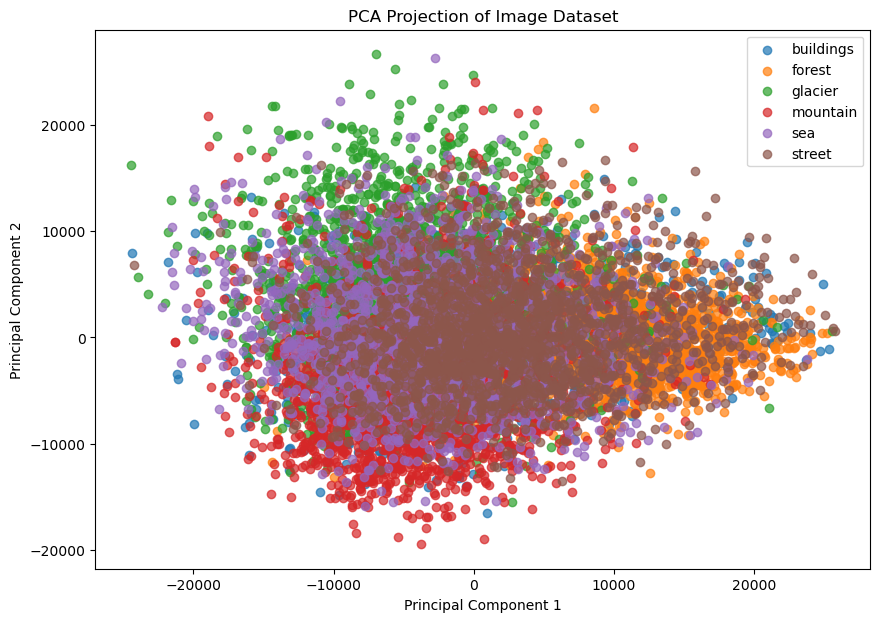

In [20]:
# Apply PCA - Train
categories = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

n_components = 2  # Reduce to 2 dimensions
pca = PCA(n_components=n_components)
train_pca = pca.fit_transform(X_train_ml)

# Visualize the result
plt.figure(figsize=(10, 7))
for label, category in enumerate(categories):
    idx = y_train_ml == label
    plt.scatter(train_pca[idx, 0], train_pca[idx, 1], label=category, alpha=0.7)
plt.title("PCA Projection of Image Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

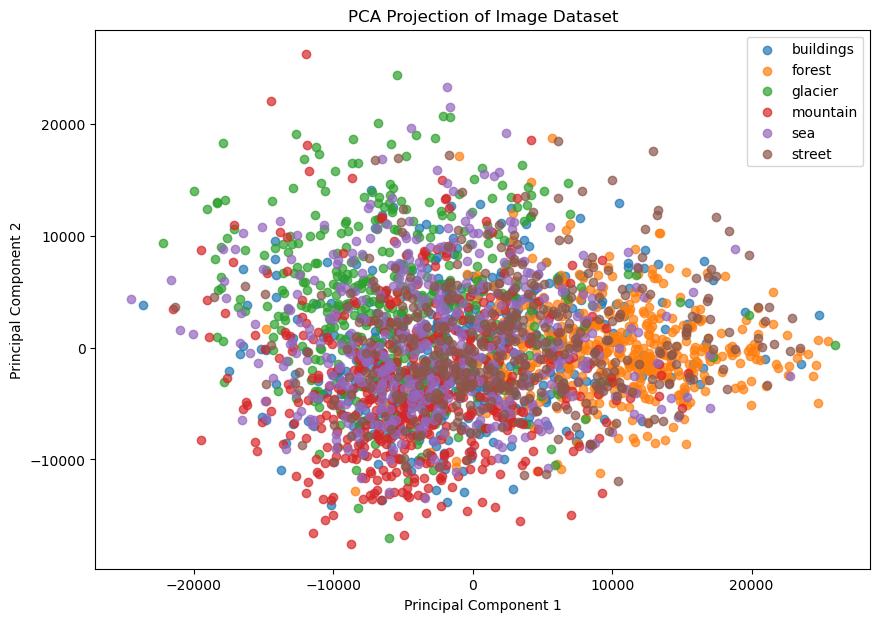

In [21]:
# Apply PCA - Validation
categories = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

n_components = 2  # Reduce to 2 dimensions
pca = PCA(n_components=n_components)
val_pca = pca.fit_transform(X_val_ml)

# Visualize the result
plt.figure(figsize=(10, 7))
for label, category in enumerate(categories):
    idx = y_val_ml == label
    plt.scatter(val_pca[idx, 0], val_pca[idx, 1], label=category, alpha=0.7)
plt.title("PCA Projection of Image Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

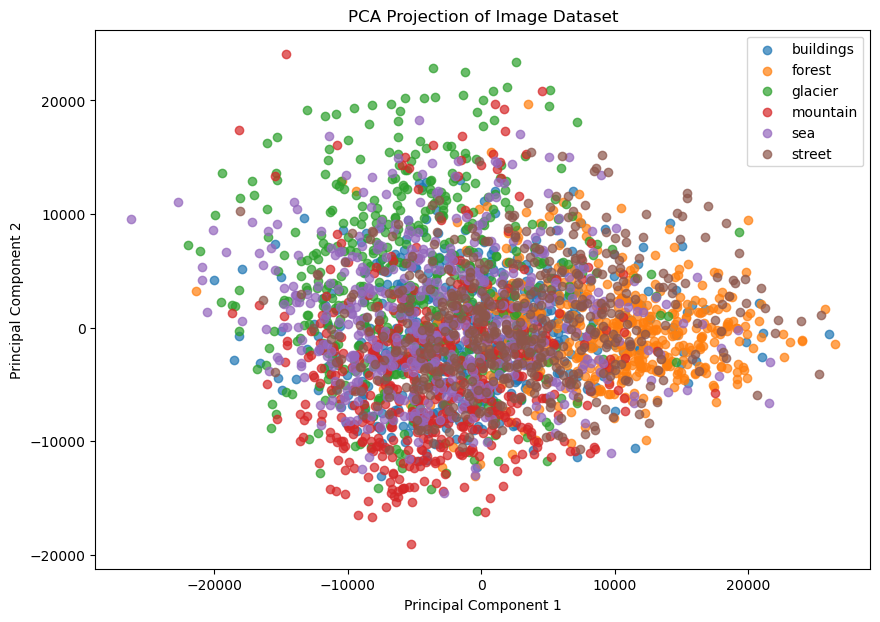

In [24]:
# Apply PCA - Test
categories = ["buildings", "forest", "glacier", "mountain", "sea", "street"]

n_components = 2  # Reduce to 2 dimensions
pca = PCA(n_components=n_components)
test_pca = pca.fit_transform(test_images_flat)

# Visualize the result
plt.figure(figsize=(10, 7))
for label, category in enumerate(categories):
    idx = test_labels == label
    plt.scatter(test_pca[idx, 0], test_pca[idx, 1], label=category, alpha=0.7)
plt.title("PCA Projection of Image Dataset")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

### Models

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
)

In [43]:
# Model classifaction results
def classification_results(X_val_perc, y_val_perc, perceptron):
    perceptron_pred = perceptron.predict(X_val_perc)

    print("\nClassification Report:\n", classification_report(y_val_perc, perceptron_pred, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))

    perceptron_cm = confusion_matrix(y_val_perc, perceptron_pred)

    perceptron_disp = ConfusionMatrixDisplay(confusion_matrix = perceptron_cm, display_labels = ['buildings','forest', 'glacier', 'mountain', 'sea', 'street'])
    perceptron_disp.plot(cmap='Blues')
    plt.title("Confusion Matrix for Perceptron")
    plt.show()

#### Perceptron

In [26]:
from sklearn.linear_model import Perceptron

In [27]:
X_train_perc, X_val_perc, y_train_perc, y_val_perc = train_test_split(
    train_images_flat,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [30]:
def train_perceptron(X_train, y_train, max_iter=2000):
    perceptron = Perceptron(max_iter=max_iter, random_state=42)
    perceptron.fit(X_train, y_train)
    return perceptron

In [ ]:
# 15 m 35.0 s
perceptron = train_perceptron(X_train_perc, y_train_perc, max_iter=2000)

##### Original Images


Classification Report:
               precision    recall  f1-score   support

   buildings       0.31      0.10      0.15       450
      forest       0.71      0.48      0.57       472
     glacier       0.15      0.29      0.19       455
    mountain       0.36      0.50      0.42       515
         sea       0.19      0.13      0.15       485
      street       0.29      0.28      0.29       430

    accuracy                           0.30      2807
   macro avg       0.33      0.30      0.30      2807
weighted avg       0.34      0.30      0.30      2807



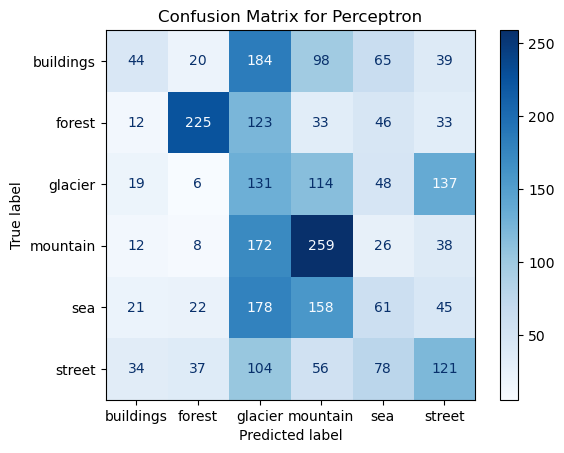

In [45]:
# Validation
# 3.5 s
classification_results(X_val_perc, y_val_perc, perceptron)



Classification Report:
               precision    recall  f1-score   support

   buildings       0.28      0.16      0.20       437
      forest       0.48      0.59      0.53       474
     glacier       0.43      0.25      0.32       553
    mountain       0.46      0.49      0.48       525
         sea       0.24      0.50      0.33       510
      street       0.64      0.30      0.41       501

    accuracy                           0.38      3000
   macro avg       0.42      0.38      0.38      3000
weighted avg       0.42      0.38      0.38      3000



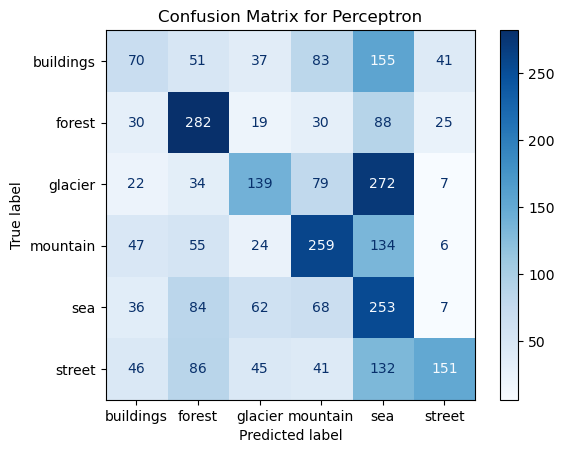

In [ ]:
# Test
# 2.0 s
classification_results(test_images_flat, test_labels, perceptron)

In [48]:
tf.keras.backend.clear_session()
gc.collect()

1697

##### HSV

In [49]:
X_train_perc, X_val_perc, y_train_perc, y_val_perc = train_test_split(
    train_hsv_features,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [ ]:
# 7 m 13.8 s
perceptron = train_perceptron(X_train_perc, y_train_perc, max_iter=2000)


Classification Report:
               precision    recall  f1-score   support

   buildings       0.33      0.16      0.21       450
      forest       0.73      0.43      0.54       472
     glacier       0.43      0.57      0.49       455
    mountain       0.32      0.79      0.45       515
         sea       0.31      0.10      0.15       485
      street       0.61      0.38      0.47       430

    accuracy                           0.41      2807
   macro avg       0.45      0.40      0.39      2807
weighted avg       0.45      0.41      0.39      2807



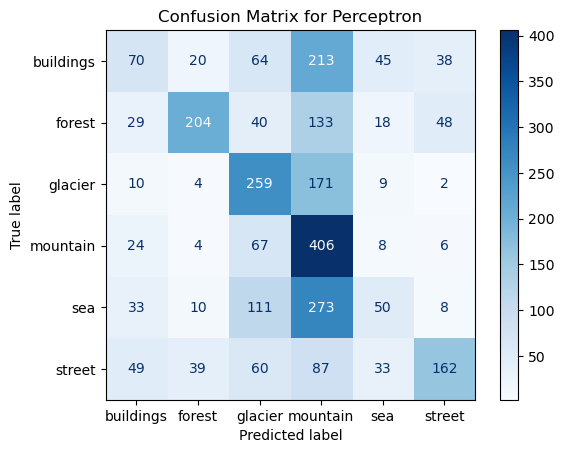

In [51]:
# Validation
# 11.8 s
classification_results(X_val_perc, y_val_perc, perceptron)


Classification Report:
               precision    recall  f1-score   support

   buildings       0.24      0.08      0.12       437
      forest       0.56      0.07      0.12       474
     glacier       0.28      0.38      0.33       553
    mountain       0.25      0.85      0.38       525
         sea       0.20      0.05      0.08       510
      street       0.58      0.13      0.21       501

    accuracy                           0.27      3000
   macro avg       0.35      0.26      0.21      3000
weighted avg       0.35      0.27      0.21      3000



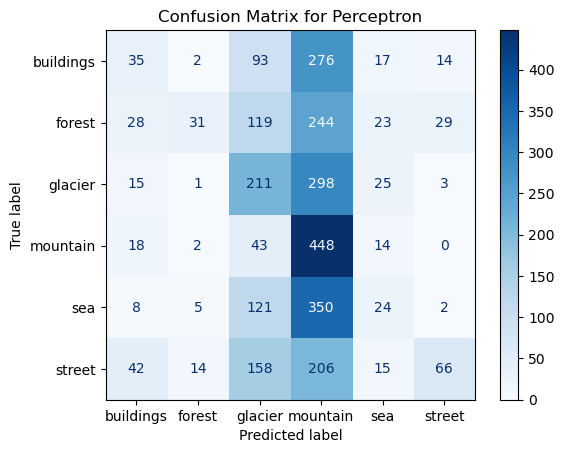

In [52]:
# Test
# 3.4 s
classification_results(test_hsv_features, test_labels, perceptron)

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

#### HOG

In [53]:
X_train_perc, X_val_perc, y_train_perc, y_val_perc = train_test_split(
    train_hog_features,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [54]:
# 10 m 31.4 s
perceptron = train_perceptron(X_train_perc, y_train_perc, max_iter=2000)


Classification Report:
               precision    recall  f1-score   support

   buildings       0.26      0.35      0.30       450
      forest       0.73      0.55      0.63       472
     glacier       0.39      0.60      0.47       455
    mountain       0.52      0.34      0.41       515
         sea       0.25      0.28      0.27       485
      street       0.61      0.39      0.47       430

    accuracy                           0.42      2807
   macro avg       0.46      0.42      0.43      2807
weighted avg       0.46      0.42      0.42      2807



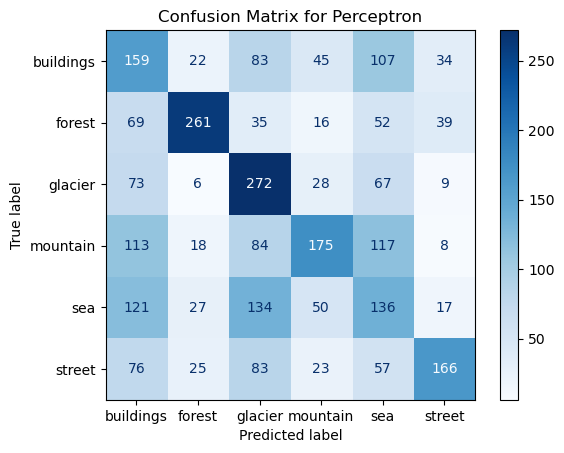

In [55]:
# Validation
# 13.5 s
classification_results(X_val_perc, y_val_perc, perceptron)


Classification Report:
               precision    recall  f1-score   support

   buildings       0.23      0.27      0.25       437
      forest       0.81      0.40      0.54       474
     glacier       0.35      0.63      0.45       553
    mountain       0.56      0.36      0.44       525
         sea       0.22      0.29      0.25       510
      street       0.63      0.31      0.42       501

    accuracy                           0.38      3000
   macro avg       0.47      0.38      0.39      3000
weighted avg       0.47      0.38      0.39      3000



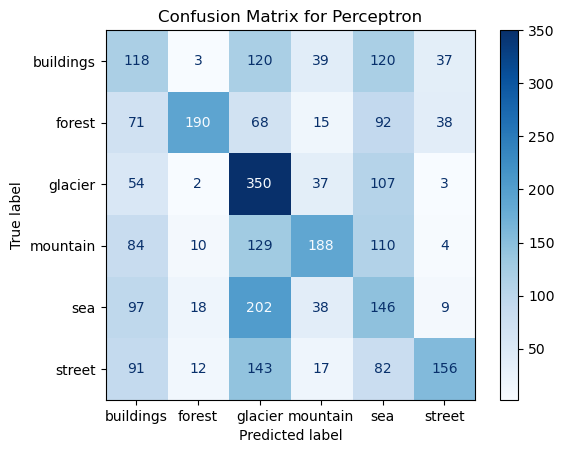

In [56]:
# Test
# 3.5 s
classification_results(test_hog_features, test_labels, perceptron)

In [57]:
tf.keras.backend.clear_session()
gc.collect()

27866

#### Logistic Regression

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [60]:
def train_logistic_regression(X_train, y_train, max_iter=2000):
    lr = LogisticRegression(multi_class='multinomial', 
                           max_iter=max_iter,
                           random_state=42)
    lr.fit(X_train, y_train)
    return lr

##### Original Images

In [59]:
X_train_logreg, X_val_logreg, y_train_logreg, y_val_logreg = train_test_split(
    train_images_flat,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [ ]:
# 47 m 5.4 s
clf = train_logistic_regression(X_train_logreg, y_train_logreg, max_iter=2000)

c:\Users\aolay\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Classification Report:
               precision    recall  f1-score   support

   buildings       0.31      0.23      0.26       450
      forest       0.76      0.49      0.60       472
     glacier       0.38      0.39      0.39       455
    mountain       0.38      0.52      0.44       515
         sea       0.26      0.33      0.29       485
      street       0.46      0.43      0.44       430

    accuracy                           0.40      2807
   macro avg       0.43      0.40      0.40      2807
weighted avg       0.43      0.40      0.40      2807



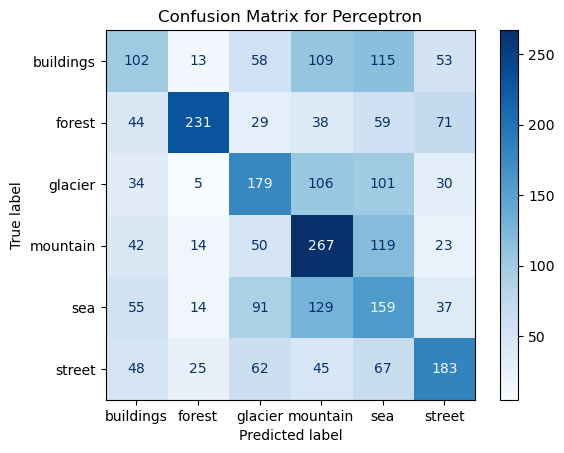

In [63]:
# Validation
# 3.5 s
classification_results(X_val_logreg, y_val_logreg, clf)


Classification Report:
               precision    recall  f1-score   support

   buildings       0.26      0.19      0.22       437
      forest       0.70      0.49      0.58       474
     glacier       0.38      0.39      0.38       553
    mountain       0.40      0.52      0.45       525
         sea       0.25      0.33      0.28       510
      street       0.52      0.45      0.48       501

    accuracy                           0.40      3000
   macro avg       0.42      0.39      0.40      3000
weighted avg       0.42      0.40      0.40      3000



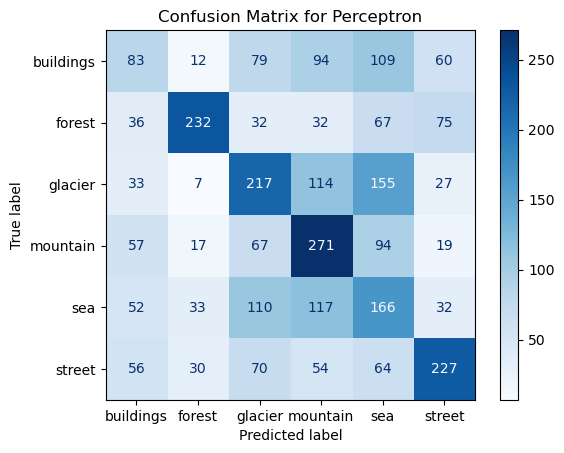

In [64]:
# Test
# 3.5 s
classification_results(test_images_flat, test_labels, clf)

##### HSV

In [65]:
X_train_logreg, X_val_logreg, y_train_logreg, y_val_logreg = train_test_split(
    train_hsv_features,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [68]:
# 45 m 28.0 s
clf = train_logistic_regression(X_train_logreg, y_train_logreg, max_iter=2000)

c:\Users\aolay\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Classification Report:
               precision    recall  f1-score   support

   buildings       0.36      0.21      0.26       450
      forest       0.68      0.51      0.59       472
     glacier       0.44      0.56      0.49       455
    mountain       0.40      0.51      0.45       515
         sea       0.30      0.37      0.33       485
      street       0.51      0.45      0.48       430

    accuracy                           0.44      2807
   macro avg       0.45      0.44      0.43      2807
weighted avg       0.45      0.44      0.44      2807



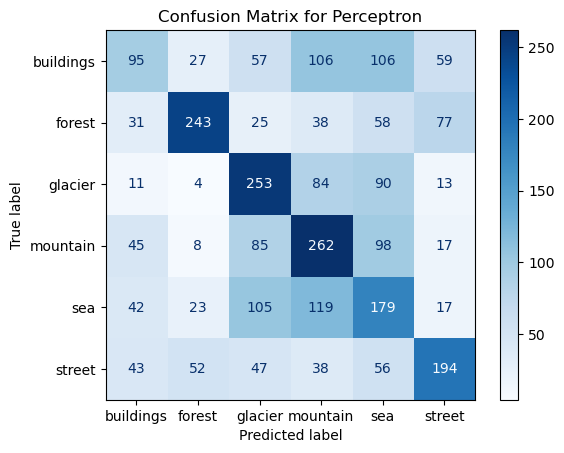

In [69]:
# Validation
# 3.5 s
classification_results(X_val_logreg, y_val_logreg, clf)


Classification Report:
               precision    recall  f1-score   support

   buildings       0.32      0.20      0.25       437
      forest       0.63      0.50      0.56       474
     glacier       0.47      0.54      0.50       553
    mountain       0.42      0.54      0.47       525
         sea       0.29      0.34      0.31       510
      street       0.53      0.46      0.49       501

    accuracy                           0.44      3000
   macro avg       0.44      0.43      0.43      3000
weighted avg       0.44      0.44      0.43      3000



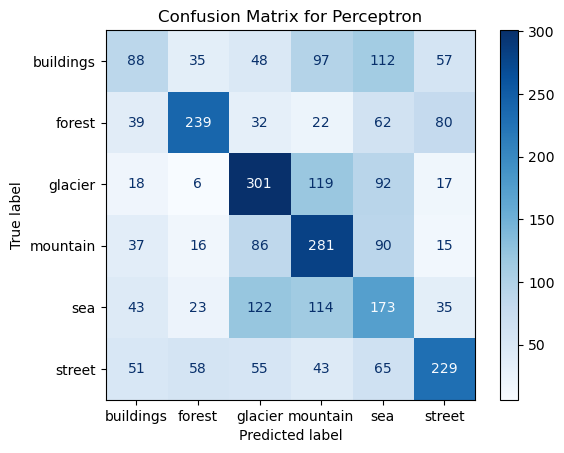

In [70]:
# Test
# 3.5 s
classification_results(test_hsv_features, test_labels, clf)

#### HOG

In [71]:
X_train_logreg, X_val_logreg, y_train_logreg, y_val_logreg = train_test_split(
    train_hog_features,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [72]:
# 29 m 42.4 s
clf = train_logistic_regression(X_train_logreg, y_train_logreg, max_iter=2000)

c:\Users\aolay\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Classification Report:
               precision    recall  f1-score   support

   buildings       0.33      0.22      0.27       450
      forest       0.78      0.54      0.64       472
     glacier       0.41      0.43      0.42       455
    mountain       0.42      0.55      0.47       515
         sea       0.25      0.33      0.29       485
      street       0.53      0.46      0.49       430

    accuracy                           0.43      2807
   macro avg       0.45      0.42      0.43      2807
weighted avg       0.45      0.43      0.43      2807



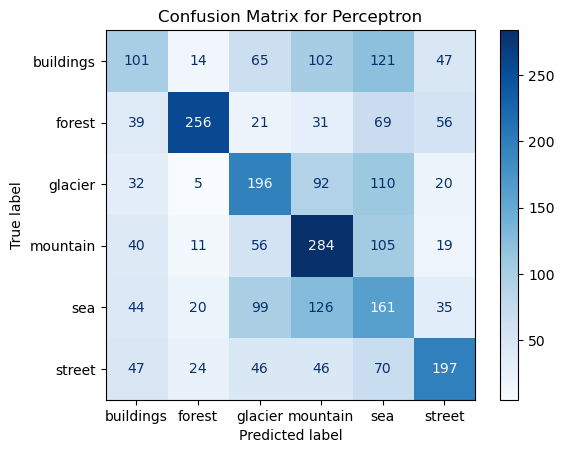

In [73]:
# Validation
# 3.5 s
classification_results(X_val_logreg, y_val_logreg, clf)


Classification Report:
               precision    recall  f1-score   support

   buildings       0.28      0.19      0.23       437
      forest       0.77      0.54      0.64       474
     glacier       0.41      0.41      0.41       553
    mountain       0.42      0.56      0.48       525
         sea       0.25      0.34      0.29       510
      street       0.56      0.48      0.52       501

    accuracy                           0.43      3000
   macro avg       0.45      0.42      0.43      3000
weighted avg       0.45      0.43      0.43      3000



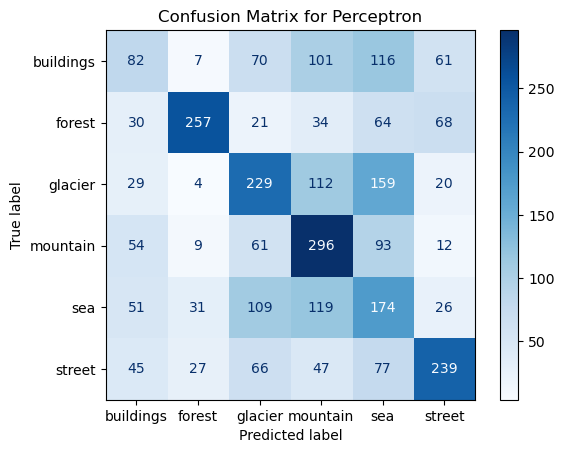

In [74]:
# Test
# 3.5 s
classification_results(test_hog_features, test_labels, clf)

In [81]:
tf.keras.backend.clear_session()
gc.collect()

1172

### SVM

In [78]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

##### HSV - PCA

In [79]:
# HOG - PCA
# Create train/validation splits
X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(
    train_hsv_features,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [80]:
X_train_scaled = scaler.fit_transform(X_train_ml)
X_val_scaled = scaler.transform(X_val_ml)


X_train_pca = pca.fit_transform(X_train_scaled)

MemoryError: Unable to allocate 5.65 GiB for an array with shape (11227, 67500) and data type float64

In [ ]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_ml)
X_val_pca = pca.transform(X_val_ml)  # Transform validation data using fitted PCA
X_test_pca = pca.transform(test_hsv_features)  # Transform test data using fitted PCA

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 1],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

svc = SVC(random_state=42, probability=True)
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='balanced_accuracy'
)

# Train on PCA-transformed training data
print("Starting Grid Search Training...")
grid_search.fit(X_train_pca, y_train_ml)

print("\n=== Grid Search Results ===")
print(f"\nBest score: {grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

# Display all parameter combinations and their scores
print("\nAll Parameter Combinations and Scores:")
results_df = pd.DataFrame(grid_search.cv_results_)
for i in range(len(results_df)):
    params = results_df.loc[i, 'params']
    mean_score = results_df.loc[i, 'mean_test_score']
    std_score = results_df.loc[i, 'std_test_score']
    print(f"\nParameters: {params}")
    print(f"Mean CV Score: {mean_score:.4f} (+/- {std_score:.4f})")
    

best_model = grid_search.best_estimator_

Starting grid search...
Fitting 3 folds for each of 9 candidates, totalling 27 fits

Total time taken: 74.81 minutes


In [ ]:

val_predictions = best_model.predict(X_val_pca)
print("Validation accuracy:", accuracy_score(y_val_ml, val_predictions))
print("\nClassification Report:\n", classification_report(y_val_perc, val_predictions, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))
print("\nValidation Classification Report:")
print(classification_report(y_val_ml, val_predictions))

In [ ]:
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(X_test_pca)
print("Validation accuracy:", accuracy_score(test_hsv_features, test_predictions))
print("\nClassification Report:\n", classification_report(test_hsv_features, test_predictions, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))
print("\nValidation Classification Report:")
print(classification_report(test_hsv_features, test_predictions))

In [ ]:
tf.keras.backend.clear_session()
gc.collect()

#### HOG - PCA

In [69]:
# HOG - PCA
# Create train/validation splits
X_train_ml, X_val_ml, y_train_ml, y_val_ml = train_test_split(
    train_hog_features,
    train_labels,
    test_size=0.2,
    random_state=42
)

In [ ]:
X_train_scaled = scaler.fit_transform(X_train_ml)
X_val_scaled = scaler.transform(X_val_ml)


X_train_pca = pca.fit_transform(X_train_scaled)

In [ ]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_ml)
X_val_pca = pca.transform(X_val_ml)  # Transform validation data using fitted PCA
X_test_pca = pca.transform(test_hog_features)  # Transform test data using fitted PCA

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.1, 1],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

svc = SVC(random_state=42, probability=True)
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='balanced_accuracy'
)

# Train on PCA-transformed training data
print("Starting Grid Search Training...")
grid_search.fit(X_train_pca, y_train_ml)

print("\n=== Grid Search Results ===")
print(f"\nBest score: {grid_search.best_score_:.4f}")
print(f"Best parameters: {grid_search.best_params_}")

# Display all parameter combinations and their scores
print("\nAll Parameter Combinations and Scores:")
results_df = pd.DataFrame(grid_search.cv_results_)
for i in range(len(results_df)):
    params = results_df.loc[i, 'params']
    mean_score = results_df.loc[i, 'mean_test_score']
    std_score = results_df.loc[i, 'std_test_score']
    print(f"\nParameters: {params}")
    print(f"Mean CV Score: {mean_score:.4f} (+/- {std_score:.4f})")
    

best_model = grid_search.best_estimator_

In [ ]:

val_predictions = best_model.predict(X_val_pca)
print("Validation accuracy:", accuracy_score(y_val_ml, val_predictions))
print("\nClassification Report:\n", classification_report(y_val_perc, val_predictions, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))
print("\nValidation Classification Report:")
print(classification_report(y_val_ml, val_predictions))

In [ ]:
best_model = grid_search.best_estimator_
test_predictions = best_model.predict(X_test_pca)
print("Validation accuracy:", accuracy_score(test_hog_features, test_predictions))
print("\nClassification Report:\n", classification_report(test_hog_features, test_predictions, target_names=['buildings','forest', 'glacier', 'mountain', 'sea', 'street']))
print("\nValidation Classification Report:")
print(classification_report(test_hog_features, test_predictions))

In [ ]:
tf.keras.backend.clear_session()
gc.collect()